In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import logomaker

# Insert path to mavenn beginning of path
import os
import sys
abs_path_to_mavenn = os.path.abspath('../../../')
sys.path.insert(0, abs_path_to_mavenn)

# Load mavenn
import mavenn
print(mavenn.__path__)

['/Users/jkinney/github/mavenn/mavenn']


In [2]:
# Load example data
data_df = mavenn.load_example(which='training_data', name='sortseq')
print(f'training N: {len(data_df)}')
data_df.head()

# Where is ct?

training N: 34333


,x,y
0,CGGTTTACACTTTATGCTTCCCGATCGTATGTTGTGTGG,9
1,GGCTTTACACTTTATGCTTACGGCTTGTTTGTTGTGTGG,4
2,GGCTTTTCAATTTTTGCTTCCGGCTCGTATGTCGTGTGG,0
3,GGCTTAACACTTGATGCGTCCAGCTCGTATGTTTTGTGT,0
4,GCCTTTACACGTTTTGCTTCCGGCTCGTATGTTGCGTGG,8


In [3]:
# Comptue sequence length and number of bins
L = len(data_df['x'][0])
Y = len(set(data_df['y']))
print(f'L={L}, Y={Y}')

L=39, Y=10


In [4]:
# Set seeed
mavenn.set_seed(0)

# Define model
model = mavenn.Model(regression_type='MPA',
                     L=L,
                     Y=Y,
                     alphabet='dna',
                     gpmap_type='additive')

# Where is ct_n?
model.set_data(x=data_df['x'],
               y=data_df['y'])

# Fit model to data
history = model.fit(learning_rate=.005,
                    epochs=1000,
                    early_stopping=True,
                    early_stopping_patience=10)

N = 34,333 observations set as training data.
Data shuffled.
Time to set data: 0.41 sec.
 
LSMR            Least-squares solution of  Ax = b

The matrix A has    34333 rows  and      156 cols
damp = 0.00000000000000e+00

atol = 1.00e-06                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =      156

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  9.733e+02  8.348e+05   1.0e+00  8.8e-01
     1  5.77894e-03  5.284e+02  1.571e+04   5.4e-01  2.9e-02  1.0e+03  1.0e+00
     2  3.35126e-02  4.775e+02  3.949e+03   4.9e-01  8.1e-03  1.0e+03  1.5e+01
     3 -6.12066e-03  4.704e+02  2.034e+03   4.8e-01  4.2e-03  1.0e+03  2.2e+01
     4 -6.01417e-02  4.678e+02  7.107e+02   4.8e-01  1.5e-03  1.0e+03  2.2e+01
     5 -6.18213e-02  4.676e+02  4.209e+02   4.8e-01  8.8e-04  1.0e+03  2.1e+01
     6 -6.21706e-02  4.675e+02  3.286e+02   4.8e-01  5.6e-04  1.3e+03  2.1e+01
     7 -6.26801e-02  4.675e+02  1.192e+02   4.8e-01  1.8e-04  1.

In [5]:
# Save model
model.save('sortseq_mpa_additive')

Model saved to these files:
	sortseq_mpa_additive.pickle
	sortseq_mpa_additive.h5


In [6]:
# Load model
model = mavenn.load('sortseq_mpa_additive')

Model loaded from these files:
	sortseq_mpa_additive.pickle
	sortseq_mpa_additive.h5


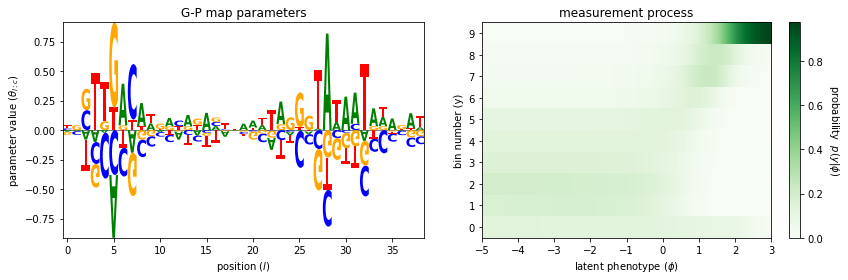

In [8]:
# Get G-P map parameters
theta_dict = model.get_theta(gauge='uniform')

# Get additive parameters suitable for logomaker
theta_logomaker_df = theta_dict['logomaker_df']

# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = model.model.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
measurement_process = model.p_of_y_given_phi(y_all, phi_grid)

# Create figure with two panels
fig, axs = plt.subplots(1,2,figsize=[12,4])

# Left panel: draw logo using logomaker
ax = axs[0]
logo = logomaker.Logo(theta_logomaker_df, ax=ax)
ax.set_ylabel(r'parameter value ($\theta_{l:c}$)')
ax.set_xlabel(r'position ($l$)')
ax.set_title('G-P map parameters')

# Right panel: draw measurement process as heatmap
ax = axs[1]
im = ax.imshow(measurement_process,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('measurement process')
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout(w_pad=3)
fig.savefig('sortseq_mpa_visualization.png')
plt.show()